In [10]:
import mbuild as mb
from mbuild.formats.hoomd_simulation import create_hoomd_simulation
import gsd
import hoomd
from utils.cg_utils import gsd_rdf
from utils.draw_scene import snap_render, display_movie
import numpy as np
import matplotlib.pyplot as plt
import freud

In [76]:
# Use Hoomd to build a simple LJ-particle system:

def build_system(packing='bcc'):
    '''
    Generate a simple LJ particle system using hoomd's create_lattice function
    packing 
    '''
    #hoomd.context.initialize("")
    if packing == 'fcc':
        system = hoomd.init.create_lattice(unitcell=(hoomd.lattice.fcc(a=1.58)), n=6)
    elif packing == 'bcc':
        system = hoomd.init.create_lattice(unitcell=(hoomd.lattice.bcc(a=1.29)), n=6)
    hoomd.dump.gsd('{}_system.gsd'.format(packing), group = hoomd.group.all(), period=None, overwrite=True)
    return system


def hoomd_simulation(packing, temp):
    
    hoomd.context.initialize("")
    system = build_system(packing)
    nl = hoomd.md.nlist.cell()
    lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl)
    lj.pair_coeff.set('A', 'A', alpha=1.0, epsilon=1.0, sigma=1.0)
    hoomd.md.integrate.mode_standard(dt=0.001)
    _all = hoomd.group.all()
    nvt = hoomd.md.integrate.nvt(group=_all, kT=temp, tau=1)
    nvt.randomize_velocities(seed=23)
    hoomd.analyze.log(filename='out.log',
                      quantities=["time", "temperature", "potential_energy"],
                      period=100,
                      overwrite=True
                     )
    hoomd.dump.gsd('{}-{}kT-trajectory.gsd'.format(packing, temp), period=5e3, group=_all, overwrite=True)
    hoomd.run(3e5)

    
def gsd_rdf(gsdfile, A_name='A', B_name='A', start=0, stop=None, rmax=None, bins=50):
    """
    This function calculates the radial distribution function given
    a gsd file and the names of the particles. By default it will calculate
    the rdf for the entire the trajectory.

    Parameters
    ----------
    gsdfile : str, filename of the gsd trajectory
    A_name, B_name : str, name(s) of particles between which to calculate the rdf
        (found in gsd.hoomd.Snapshot.particles.types)
    start : int, which frame to start accumulating the rdf (default 0)
        (negative numbers index from the end)
    stop : int, which frame to stop accumulating the rdf (default None)
        If none is given, the function will default to the last frame.
    rmax : float, maximum radius to consider. (default None)
        If none is given, it'll be the minimum box length / 4
    rdf : freud.density.RDF, if provided, this function will accumulate an average rdf,
        otherwise it will provide the rdf only for the given compound. (default None)
    bins : int, number of bins to use when calculating the distribution.

    Returns
    -------
    freud.density.RDF
    """
    f = gsd.pygsd.GSDFile(open(gsdfile, "rb"))
    t = gsd.hoomd.HOOMDTrajectory(f)
    snap = t[0]
    if start < -len(t):
        raise IndexError(
                f"Can't index beyond first frame: {len(t)} frames in gsd file"
                )
    if rmax is None:
        rmax = max(snap.configuration.box[:3]) * 0.45

    rdf = freud.density.RDF(bins, rmax)

    if stop is None:
        stop = len(t) - 1
    if start < 0:
        start += len(t)
    for frame in range(start, stop):
        snap = t[frame]
        box = freud.box.Box(*snap.configuration.box)
        A_pos = snap.particles.position[
                snap.particles.typeid == snap.particles.types.index(A_name)
                ]
        pos = A_pos
        if A_name != B_name:
            B_pos = snap.particles.position[
                    snap.particles.typeid == snap.particles.types.index(B_name)
                    ]
            pos = np.concatenate((A_pos, B_pos))

        n_query = freud.locality.AABBQuery.from_system((
            box, pos
        ))
        rdf.compute(n_query, reset=False)
    return rdf

def rdf_from_gsd(gsd_file, r_max=None, r_min=0.1, nbins=50):
    f = gsd.pygsd.GSDFile(open(gsd_file, "rb"))
    trajectory = gsd.hoomd.HOOMDTrajectory(f)
    
    if r_max is None:
        r_max = max(trajectory[0].configuration.box[:3]) * 0.45
    freud_rdf = freud.density.RDF(bins=nbins, r_max=r_max, r_min=r_min)
    for frame in trajectory:
        freud_rdf.compute(system=frame, reset=False)
    return freud_rdf

In [34]:
bcc_system = build_system('bcc')

notice(2): Group "all" created containing 432 particles


In [74]:
bcc_rdf = rdf_from_gsd('bcc_system.gsd')

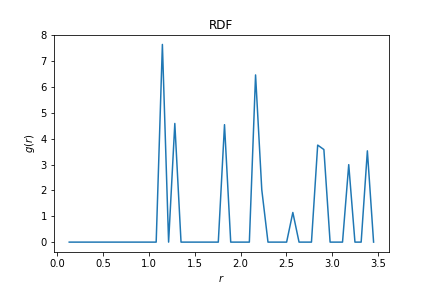

In [75]:
bcc_rdf

In [77]:
bcc_cold = hoomd_simulation(packing='bcc', temp=0.3)

notice(2): Group "all" created containing 432 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 432
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 31001 / 300000 | TPS 3099.56 | ETA 00:01:26
Time 00:00:20 | Step 62168 / 300000 | TPS 3116.65 | ETA 00:01:16
Time 00:00:30 | Step 95001 / 300000 | TPS 3282.79 | ETA 00:01:02
Time 00:00:40 | Step 128127 / 300000 | TPS 3312.52 | ETA 00:00:51
Time 00:00:50 | Step 161094 / 300000 | TPS 3296.65 | ETA 00:00:42
Time 00:01:00 | Step 194201 / 300000 | TPS 3310.26 | ETA 00:00:31
Time 00:01:10 | Step 227054 / 300000 | TPS 3285.23 | ETA 00:00:22
Time 00:01:20 | Step 259682 / 300000 | TPS 3262.73 | ETA 00:00:12
Time 00:01:30 | Step 291972 / 300000 | TPS 3228.95 | ETA 00:00:02
Time 00:01:32 | Step 300000 / 300000 | TPS 3255.23 | ETA 00:00:00
Average TPS: 3244.2
---------
-- Neighborlist 

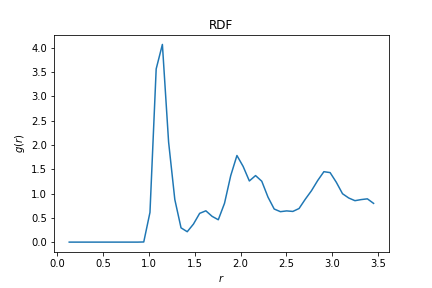

In [78]:
bcc_cold_rdf = rdf_from_gsd('bcc-0.3-trajectory.gsd')
bcc_cold_rdf

In [ ]:
bcc_cold_rdf = rdf_from_gsd('bcc-0.3-trajectory.gsd')
bcc_cold_rdf

In [81]:
bcc_hot = hoomd_simulation(packing='bcc', temp=4)

notice(2): Group "all" created containing 432 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 432
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 26961 / 300000 | TPS 2695.8 | ETA 00:01:41
Time 00:00:20 | Step 54570 / 300000 | TPS 2760.89 | ETA 00:01:28
Time 00:00:30 | Step 81237 / 300000 | TPS 2666.66 | ETA 00:01:22
Time 00:00:40 | Step 108363 / 300000 | TPS 2712.57 | ETA 00:01:10
Time 00:00:50 | Step 136199 / 300000 | TPS 2783.54 | ETA 00:00:58
Time 00:01:00 | Step 164111 / 300000 | TPS 2791.13 | ETA 00:00:48
Time 00:01:10 | Step 191960 / 300000 | TPS 2784.86 | ETA 00:00:38
Time 00:01:20 | Step 219654 / 300000 | TPS 2769.38 | ETA 00:00:29
Time 00:01:30 | Step 247473 / 300000 | TPS 2781.84 | ETA 00:00:18
Time 00:01:40 | Step 275623 / 300000 | TPS 2814.92 | ETA 00:00:08
Time 00:01:48 | Step 300000 / 300000 | TPS 2825

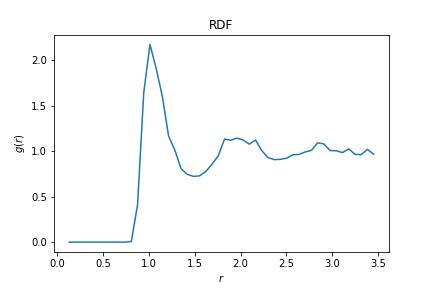

In [82]:
bcc_hot_rdf = rdf_from_gsd('bcc-4-trajectory.gsd')
bcc_hot_rdf